In [1]:
import numpy as np
import fitsio
import matplotlib.pyplot as plt
import h5py
from scipy import interpolate
import os
from astropy.table import Table, hstack
from astropy.io import fits
import tqdm
import scipy.optimize
from astropy.table import Table, vstack

In [2]:
dpi = 150
plt.rcParams['figure.dpi']= dpi
plt.rc("savefig", dpi=dpi)
plt.rc('font', size=10)
plt.rc('xtick', direction='in') 
plt.rc('ytick', direction='in')
plt.rc('xtick.major', pad=5) 
plt.rc('xtick.minor', pad=5)
plt.rc('ytick.major', pad=5) 
plt.rc('ytick.minor', pad=5)
plt.rcParams['lines.linewidth'] = 1
plt.rcParams['lines.markersize'] = 3
plt.rc('lines', dotted_pattern = [2., 2.])

## Make maps for mean $p,q,w$

In [3]:
with h5py.File('/project2/chihway/dhayaa/DECADE/star_psf_shapecat.hdf5', 'r') as f:
    
    print(list(f.keys()))
    Ntot = len(f['MAGZP'])
    print(Ntot)

million = 1000000
nbin = 128
Npatch = np.ceil(Ntot/million).astype(np.int_)
print(Npatch)
nbinx = 130
nbiny = 140

['BAND', 'CCDNUM', 'EXPNUM', 'FLUXERR_APER_8', 'FLUXERR_AUTO', 'FLUX_APER_8', 'FLUX_AUTO', 'IMAFLAGS_ISO', 'MAGZP', 'MAG_AUTO', 'T_model_hsm', 'T_star_hsm', 'dec', 'focal_x', 'focal_y', 'g1_model_hsm', 'g1_star_hsm', 'g2_model_hsm', 'g2_star_hsm', 'pix_x', 'pix_y', 'ra']
265389605
266


In [146]:
xbin = np.linspace(1,26625,nbinx+1) # 12*2048+2048+1
ybin = np.linspace(1,28673,nbiny+1) # 6*4096+4096+1
q1_hist = np.zeros((nbiny,nbinx))
q2_hist = np.zeros((nbiny,nbinx))
p1_hist = np.zeros((nbiny,nbinx))
p2_hist = np.zeros((nbiny,nbinx))
w1_hist = np.zeros((nbiny,nbinx))
w2_hist = np.zeros((nbiny,nbinx))
count_hist = np.zeros((nbiny,nbinx))

for i in tqdm.trange(Npatch): 
    
    start = i*million
    stop = (i+1)*million
    with h5py.File('/project2/chihway/dhayaa/DECADE/star_psf_shapecat.hdf5', 'r') as f:
        
        # 'MAG_AUTO' is actually Flag. Flag and S2N > 40 cut
        mask  = (np.array(f['MAG_AUTO'][start:stop])==0)*(np.array(f['FLUX_APER_8'][start:stop])/np.array(f['FLUXERR_APER_8'][start:stop])>40)
        p1 = np.array(f['g1_model_hsm'][start:stop])[mask]
        p2 = np.array(f['g2_model_hsm'][start:stop])[mask]
        star_e1 = np.array(f['g1_star_hsm'][start:stop])[mask]
        star_e2 = np.array(f['g2_star_hsm'][start:stop])[mask]
        focal_x = np.array(f['focal_x'][start:stop])[mask]
        focal_y = np.array(f['focal_y'][start:stop])[mask]
        T_star = np.array(f['T_star_hsm'][start:stop])[mask]
        T_psf = np.array(f['T_model_hsm'][start:stop])[mask] 

    q1 = star_e1 - p1
    q2 = star_e2 - p2

    w1 = star_e1*(T_star-T_psf)/T_star
    w2 = star_e2*(T_star-T_psf)/T_star

    ind_x = np.digitize(focal_x,xbin,right=True)-1
    ind_y = np.digitize(focal_y,ybin,right=True)-1
    ind_a = nbiny*ind_x+ind_y # 2d bin index --> 1d bin index

    q1_ = np.bincount(ind_a,q1,minlength=nbinx*nbiny) # sum e1_s with the same ind_a
    q2_ = np.bincount(ind_a,q2,minlength=nbinx*nbiny) # sum e2_s with the same ind_a
    p1_ = np.bincount(ind_a,p1,minlength=nbinx*nbiny)
    p2_ = np.bincount(ind_a,p2,minlength=nbinx*nbiny)
    w1_ = np.bincount(ind_a,w1,minlength=nbinx*nbiny)
    w2_ = np.bincount(ind_a,w2,minlength=nbinx*nbiny)
    N = np.bincount(ind_a,np.ones(len(q1)),minlength=nbinx*nbiny)

    # back to 2d bin index
    categories = np.arange(nbinx*nbiny)
    ind_x = categories//nbiny
    ind_y = categories%nbiny

    count_hist[ind_y,ind_x] += N
    q1_hist[ind_y,ind_x] += q1_
    q2_hist[ind_y,ind_x] += q2_
    p1_hist[ind_y,ind_x] += p1_
    p2_hist[ind_y,ind_x] += p2_
    w1_hist[ind_y,ind_x] += w1_
    w2_hist[ind_y,ind_x] += w2_

q1_hist = q1_hist/count_hist
q1_hist[np.isnan(q1_hist)] = 0
q2_hist = q2_hist/count_hist
q2_hist[np.isnan(q2_hist)] = 0
p1_hist = p1_hist/count_hist
p1_hist[np.isnan(p1_hist)] = 0
p2_hist = p2_hist/count_hist
p2_hist[np.isnan(p2_hist)] = 0
w1_hist = w1_hist/count_hist
w1_hist[np.isnan(w1_hist)] = 0
w2_hist = w2_hist/count_hist
w2_hist[np.isnan(w2_hist)] = 0

100%|██████████| 266/266 [17:02<00:00,  3.84s/it]
/software/python-anaconda-2020.02-el7-x86_64/lib/python3.7/site-packages/ipykernel_launcher.py:58: RuntimeWarning: invalid value encountered in true_divide
/software/python-anaconda-2020.02-el7-x86_64/lib/python3.7/site-packages/ipykernel_launcher.py:60: RuntimeWarning: invalid value encountered in true_divide
/software/python-anaconda-2020.02-el7-x86_64/lib/python3.7/site-packages/ipykernel_launcher.py:62: RuntimeWarning: invalid value encountered in true_divide
/software/python-anaconda-2020.02-el7-x86_64/lib/python3.7/site-packages/ipykernel_launcher.py:64: RuntimeWarning: invalid value encountered in true_divide
/software/python-anaconda-2020.02-el7-x86_64/lib/python3.7/site-packages/ipykernel_launcher.py:66: RuntimeWarning: invalid value encountered in true_divide
/software/python-anaconda-2020.02-el7-x86_64/lib/python3.7/site-packages/ipykernel_launcher.py:68: RuntimeWarning: invalid value encountered in true_divide


In [4]:
xbin = np.linspace(1,26625,nbinx+1) # 12*2048+2048+1
ybin = np.linspace(1,28673,nbiny+1) # 6*4096+4096+1

dir_name = '/project/chihway/jackie/decade/rowe_stats/'
count_hist = np.load(dir_name+'count_hist'+f'_{nbinx}_{nbiny}.npy')
q1_hist = np.load(dir_name+'q1_hist'+f'_{nbinx}_{nbiny}.npy')
q2_hist = np.load(dir_name+'q2_hist'+f'_{nbinx}_{nbiny}.npy')
p1_hist = np.load(dir_name+'p1_hist'+f'_{nbinx}_{nbiny}.npy')
p2_hist = np.load(dir_name+'p2_hist'+f'_{nbinx}_{nbiny}.npy')
w1_hist = np.load(dir_name+'w1_hist'+f'_{nbinx}_{nbiny}.npy')
w2_hist = np.load(dir_name+'w2_hist'+f'_{nbinx}_{nbiny}.npy')

q1_hist = np.where(count_hist>1000, q1_hist, np.nan)
q2_hist = np.where(count_hist>1000, q2_hist, np.nan)
p1_hist = np.where(count_hist>1000, p1_hist, np.nan)
p2_hist = np.where(count_hist>1000, p2_hist, np.nan)
w1_hist = np.where(count_hist>1000, w1_hist, np.nan)
w2_hist = np.where(count_hist>1000, w2_hist, np.nan)

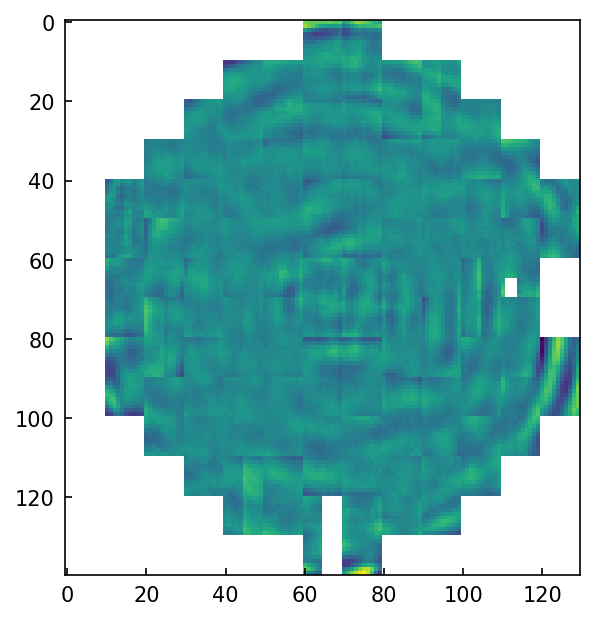

In [5]:
plt.imshow(q1_hist)

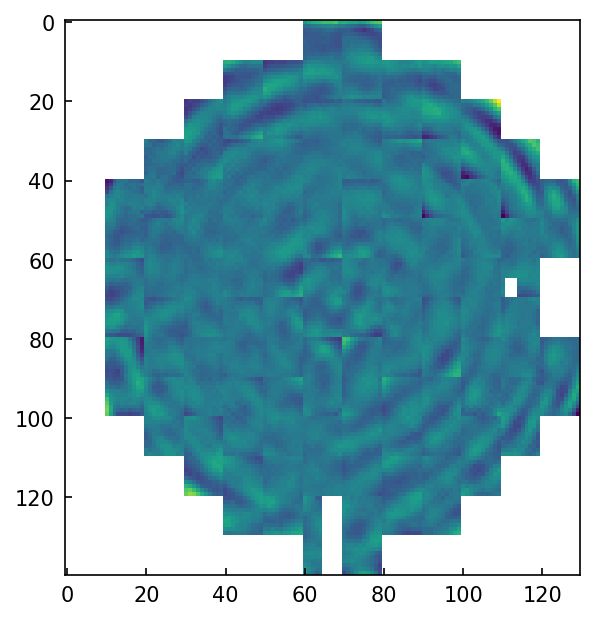

In [33]:
plt.imshow(q2_hist)

In [30]:
#dir_name = '/project/chihway/jackie/decade/rowe_stats/'
#np.save(dir_name+'count_hist'+f'_{nbinx}_{nbiny}.npy',count_hist)
#np.save(dir_name+'q1_hist'+f'_{nbinx}_{nbiny}.npy',q1_hist)
#np.save(dir_name+'q2_hist'+f'_{nbinx}_{nbiny}.npy',q2_hist)
#np.save(dir_name+'p1_hist'+f'_{nbinx}_{nbiny}.npy',p1_hist)
#np.save(dir_name+'p2_hist'+f'_{nbinx}_{nbiny}.npy',p2_hist)
#np.save(dir_name+'w1_hist'+f'_{nbinx}_{nbiny}.npy',w1_hist)
#np.save(dir_name+'w2_hist'+f'_{nbinx}_{nbiny}.npy',w2_hist)

## Obtain mean $p,q,w$

In [7]:
from scipy.interpolate import CloughTocher2DInterpolator

In [8]:
xcenter = 0.5*(xbin[1:]+xbin[:-1])
ycenter = 0.5*(ybin[1:]+ybin[:-1])

xs, ys = np.meshgrid(xcenter,ycenter)
coord = np.array([xs.reshape(-1),ys.reshape(-1)]).T
count_1d = count_hist.reshape(-1)
q1_1d = q1_hist.reshape(-1)
q2_1d = q2_hist.reshape(-1)
p1_1d = p1_hist.reshape(-1)
p2_1d = p2_hist.reshape(-1)
w1_1d = w1_hist.reshape(-1)
w2_1d = w2_hist.reshape(-1)

mask = count_1d>1000

In [9]:
count_interpolator = CloughTocher2DInterpolator(coord[mask], count_1d[mask])
q1_interpolator = CloughTocher2DInterpolator(coord[mask], q1_1d[mask])
q2_interpolator = CloughTocher2DInterpolator(coord[mask], q2_1d[mask])
p1_interpolator = CloughTocher2DInterpolator(coord[mask], p1_1d[mask])
p2_interpolator = CloughTocher2DInterpolator(coord[mask], p2_1d[mask])
w1_interpolator = CloughTocher2DInterpolator(coord[mask], w1_1d[mask])
w2_interpolator = CloughTocher2DInterpolator(coord[mask], w2_1d[mask])

In [10]:
# domains for interpolation (if needed)

mask2d = np.where(count_hist >= 1000, True, False)
#mask2d_1 = mask2d[1:,1:]
#mask2d_2 = mask2d[1:,:-1]
#mask2d_3 = mask2d[:-1,1:]
#mask2d_4 = mask2d[:-1,:-1]
#domain = mask2d_1*mask2d_2*mask2d_3*mask2d_4

#plt.imshow(domain)

### load catalog and compute focal plane coord

In [31]:
dtype = [('q1', '>f8'),
         ('q2', '>f8'),
         ('p1', '>f8'),
         ('p2', '>f8'),
         ('w1', '>f8'),
         ('w2', '>f8'),
        ]

nbinx, nbiny = 130, 140

In [26]:
fnames = []
for i in os.listdir('/project/chihway/data/decade/shearcat_v2'):
    if i.startswith('metacal'):
        fnames.append(i)
len(fnames)

3057

In [36]:
corners = np.loadtxt('/project2/chihway/dhayaa/FocalPlaneCoordOffsets.txt')

readable = []
unreadable = []

for fname in tqdm.tqdm(fnames): 
    try: 
        new = fitsio.read(f'/project/chihway/data/decade/shearcat_v2/{fname}')
        readable.append(fname)
    except: 
        unreadable.append(fname)
        continue
        
    
    ccdnum_s = new['ccdnum']
    x_exp_s = new['x_exp']
    y_exp_s = new['y_exp']

    x_focal_s = -np.nan*np.ones_like(ccdnum_s)
    y_focal_s = -np.nan*np.ones_like(ccdnum_s)

    q1_interp = -np.nan*np.ones_like(ccdnum_s)
    q2_interp = -np.nan*np.ones_like(ccdnum_s)
    p1_interp = -np.nan*np.ones_like(ccdnum_s)
    p2_interp = -np.nan*np.ones_like(ccdnum_s)
    w1_interp = -np.nan*np.ones_like(ccdnum_s)
    w2_interp = -np.nan*np.ones_like(ccdnum_s)
    domain_mask = np.zeros_like(ccdnum_s).astype(np.bool_)


    for i in range(0,3): 
        for j in range(0,20):
            coordmask = ccdnum_s[:,i,j]!=-9999
            offset_x, offset_y = corners[:,ccdnum_s[coordmask,i,j]]
            x_focal_s[coordmask,i,j] = offset_x + x_exp_s[coordmask,i,j]
            y_focal_s[coordmask,i,j] = offset_y + y_exp_s[coordmask,i,j] 
            coord = np.array([x_focal_s[coordmask,i,j],y_focal_s[coordmask,i,j]]).T

            #q1_interp[coordmask,i,j] = q1_interpolator(coord)
            #q2_interp[coordmask,i,j] = q2_interpolator(coord)
            #p1_interp[coordmask,i,j] = p1_interpolator(coord)
            #p2_interp[coordmask,i,j] = p2_interpolator(coord)
            #w1_interp[coordmask,i,j] = w1_interpolator(coord)
            #w2_interp[coordmask,i,j] = w2_interpolator(coord)

            ind_x = np.digitize(x_focal_s[coordmask,i,j],xbin,right=True)-1
            ind_y = np.digitize(y_focal_s[coordmask,i,j],ybin,right=True)-1
            
            q1_interp[coordmask,i,j] = q1_hist[ind_y, ind_x]
            q2_interp[coordmask,i,j] = q2_hist[ind_y, ind_x]
            p1_interp[coordmask,i,j] = p1_hist[ind_y, ind_x]
            p2_interp[coordmask,i,j] = p2_hist[ind_y, ind_x]
            w1_interp[coordmask,i,j] = w1_hist[ind_y, ind_x]
            w2_interp[coordmask,i,j] = w2_hist[ind_y, ind_x]

    results = np.zeros(len(new),dtype=dtype)
    results['q1'] = np.nanmean(q1_interp,axis=(1,2))
    results['q2'] = np.nanmean(q2_interp,axis=(1,2))
    results['p1'] = np.nanmean(p1_interp,axis=(1,2))
    results['p2'] = np.nanmean(p2_interp,axis=(1,2))
    results['w1'] = np.nanmean(w1_interp,axis=(1,2))
    results['w2'] = np.nanmean(w2_interp,axis=(1,2))

    fitsio.write(f'/project/chihway/jackie/decade/rowe_stats/interp/{fname[:-5]}_binned.fits',results,clobber=False)

100%|███████████████████████████████████████████████████████████████████████████████| 2989/2989 [49:51<00:00,  1.00s/it]


In [24]:
A = np.array([
    [[0,0,0,np.nan], [4, np.nan, np.nan, np.nan]]
])

In [25]:
np.nanmean(A,axis=(2,1))

array([1.])

## Calibration

In [7]:
fnames = os.listdir('/project/chihway/jackie/decade/rowe_stats/interp')
readable = []
for fname in fnames: 
    if 'binned' in fname:
        readable.append(fname)

In [8]:
# determine bin edges
fnames = os.listdir('/project/chihway/jackie/decade/rowe_stats/interp')

q1_bin = np.linspace(1.1*np.nanmin(q1_hist),1.1*np.nanmax(q1_hist),40000)
q2_bin = np.linspace(1.1*np.nanmin(q2_hist),1.1*np.nanmax(q2_hist),40000)
p1_bin = np.linspace(1.1*np.nanmin(p1_hist),1.1*np.nanmax(p1_hist),40000)
p2_bin = np.linspace(1.1*np.nanmin(p2_hist),1.1*np.nanmax(p2_hist),40000)
w1_bin = np.linspace(1.1*np.nanmin(w1_hist),1.1*np.nanmax(w1_hist),40000)
w2_bin = np.linspace(1.1*np.nanmin(w2_hist),1.1*np.nanmax(w2_hist),40000)

w1_count = np.zeros(40001)
p2_count = np.zeros(40001)
p1_count = np.zeros(40001)
q1_count = np.zeros(40001)
q2_count = np.zeros(40001)
w2_count = np.zeros(40001)


for fname in tqdm.tqdm(readable[:]):
    result = fitsio.read(f'/project/chihway/jackie/decade/rowe_stats/interp/{fname[:-12]}_binned.fits')
    new = fitsio.read(f'/project/chihway/data/decade/shearcat_v2/{fname[:-12]}.fits')
    
    keys = ['q1', 'q2', 'p1', 'p2', 'w1', 'w2']
    interp_mask = np.sum(np.array([np.isnan(result[key]) for key in keys]),axis=0)==0
    mask0 = (~((new['mcal_T_noshear'][:]>2)*(new['mcal_s2n_noshear'][:]<30)))*(new['mcal_T_noshear'][:]<10)*(new['mcal_s2n_noshear'][:]<1000)*(new['mcal_s2n_noshear'][:]>10)*(new['mcal_T_ratio_noshear'][:]>0.5)
    mask = interp_mask*mask0
    
    q1_count += np.bincount( np.digitize(result['q1'][mask],q1_bin), minlength=40001)
    q2_count += np.bincount( np.digitize(result['q2'][mask],q2_bin), minlength=40001)
    p1_count += np.bincount( np.digitize(result['p1'][mask],p1_bin), minlength=40001)
    p2_count += np.bincount( np.digitize(result['p2'][mask],p2_bin), minlength=40001)
    w1_count += np.bincount( np.digitize(result['w1'][mask],w1_bin), minlength=40001)
    w2_count += np.bincount( np.digitize(result['w2'][mask],w2_bin), minlength=40001)

    
q1_cdf = 100*(np.cumsum(q1_count)/np.sum(q1_count))
q2_cdf = 100*(np.cumsum(q2_count)/np.sum(q2_count))
p1_cdf = 100*(np.cumsum(p1_count)/np.sum(p1_count))
p2_cdf = 100*(np.cumsum(p2_count)/np.sum(p2_count))
w1_cdf = 100*(np.cumsum(w1_count)/np.sum(w1_count))
w2_cdf = 100*(np.cumsum(w2_count)/np.sum(w2_count))


q1_edges = q1_bin[np.searchsorted(q1_cdf,np.arange(5,96,5))]
q2_edges = q2_bin[np.searchsorted(q2_cdf,np.arange(5,96,5))]
p1_edges = p1_bin[np.searchsorted(p1_cdf,np.arange(5,96,5))]
p2_edges = p2_bin[np.searchsorted(p2_cdf,np.arange(5,96,5))]
w1_edges = w1_bin[np.searchsorted(w1_cdf,np.arange(5,96,5))]
w2_edges = w2_bin[np.searchsorted(w2_cdf,np.arange(5,96,5))]


print(q1_cdf[np.searchsorted(q1_cdf,np.arange(5,96,5))])
print(q2_cdf[np.searchsorted(q2_cdf,np.arange(5,96,5))])
print(p1_cdf[np.searchsorted(p1_cdf,np.arange(5,96,5))])
print(p2_cdf[np.searchsorted(p2_cdf,np.arange(5,96,5))])
print(w1_cdf[np.searchsorted(w1_cdf,np.arange(5,96,5))])
print(w2_cdf[np.searchsorted(w2_cdf,np.arange(5,96,5))])


100%|███████████████████████████████████████████████████████████████████████████████| 2982/2982 [23:41<00:00,  2.10it/s]

[ 5.00655971 10.0070798  15.01881976 20.01955641 25.0258583  30.01397603
 35.02190385 40.02353424 45.01079604 50.01360891 55.00842969 60.03110765
 65.03321585 70.00220066 75.00781163 80.00566425 85.00737026 90.00574881
 95.00310987]
[ 5.00175757 10.01012882 15.01174546 20.00745998 25.01520905 30.01273167
 35.01804702 40.01263061 45.01973344 50.02016759 55.03460939 60.02552178
 65.01809789 70.00410502 75.01239721 80.01750974 85.01694359 90.00055481
 95.00348112]
[ 5.00283694 10.0049142  15.00546178 20.00138598 25.00071327 30.00179367
 35.00528716 40.0071513  45.00657827 50.00916771 55.01087372 60.01621313
 65.00209995 70.01283617 75.0092588  80.00105805 85.00265406 90.00497538
 95.0016627 ]
[ 5.00157883 10.00445358 15.00401117 20.00923027 25.00942036 30.00903984
 35.01053273 40.00350415 45.01121197 50.01214111 55.01048873 60.00720354
 65.01031204 70.00127255 75.00621665 80.00523113 85.00689589 90.00228041
 95.00048021]
[ 5.00146883 10.00774666 15.00950424 20.02020609 25.03250636 30.0181

In [9]:
keys = ['q1', 'q2', 'p1', 'p2', 'w1', 'w2']

edges = {'q1':q1_edges, 'q2':q2_edges, 'p1':p1_edges,
         'p2':p2_edges, 'w1':w1_edges, 'w2':w2_edges}

zeros = np.array([np.zeros(20) for _ in range(6)])

### mean shear

In [27]:
def mask_default(cat, interp):
    mask0_default = (~((cat['mcal_T_noshear'][:]>2)*(cat['mcal_s2n_noshear'][:]<30)))*(cat['mcal_T_noshear'][:]<10)*(cat['mcal_s2n_noshear'][:]<1000)*(cat['mcal_s2n_noshear'][:]>10)*(cat['mcal_T_ratio_noshear'][:]>0.5)
    mask_1p_default = (~((cat['mcal_T_1p'][:]>2)*(cat['mcal_s2n_1p'][:]<30)))*(cat['mcal_T_1p'][:]<10)*(cat['mcal_s2n_1p'][:]<1000)*(cat['mcal_s2n_1p'][:]>10)*(cat['mcal_T_ratio_1p'][:]>0.5)
    mask_1m_default = (~((cat['mcal_T_1m'][:]>2)*(cat['mcal_s2n_1m'][:]<30)))*(cat['mcal_T_1m'][:]<10)*(cat['mcal_s2n_1m'][:]<1000)*(cat['mcal_s2n_1m'][:]>10)*(cat['mcal_T_ratio_1m'][:]>0.5)
    mask_2p_default = (~((cat['mcal_T_2p'][:]>2)*(cat['mcal_s2n_2p'][:]<30)))*(cat['mcal_T_2p'][:]<10)*(cat['mcal_s2n_2p'][:]<1000)*(cat['mcal_s2n_2p'][:]>10)*(cat['mcal_T_ratio_2p'][:]>0.5)
    mask_2m_default = (~((cat['mcal_T_2m'][:]>2)*(cat['mcal_s2n_2m'][:]<30)))*(cat['mcal_T_2m'][:]<10)*(cat['mcal_s2n_2m'][:]<1000)*(cat['mcal_s2n_2m'][:]>10)*(cat['mcal_T_ratio_2m'][:]>0.5)
    
    #keys = ['q1', 'q2', 'p1', 'p2', 'w1', 'w2']
    interp_mask = ~np.isnan(result['q1'])

    return mask0_default*interp_mask, mask_1p_default*interp_mask, mask_1m_default*interp_mask, mask_2p_default*interp_mask, mask_2m_default*interp_mask

In [28]:
# compute the mean shear
dgamma = 2*0.01

e1 = zeros.copy()
e2 = zeros.copy()

g1p = zeros.copy()
g1m = zeros.copy()
g2p = zeros.copy()
g2m = zeros.copy()
gs1p = zeros.copy()
gs1m = zeros.copy()
gs2p = zeros.copy()
gs2m = zeros.copy()

count0 = zeros.copy()
count1p = zeros.copy()
count1m = zeros.copy()
count2p = zeros.copy()
count2m = zeros.copy()

q1_binned = zeros.copy()
q2_binned = zeros.copy()
p1_binned = zeros.copy()
p2_binned = zeros.copy()
w1_binned = zeros.copy()
w2_binned = zeros.copy()

X = zeros.copy()

for fname in tqdm.tqdm(readable[:]):
    new = fitsio.read(f'/project/chihway/data/decade/shearcat_v2/{fname[:-12]}.fits')
    result = fitsio.read(f'/project/chihway/jackie/decade/rowe_stats/interp/{fname[:-12]}_binned.fits')
    df0, df1p, df1m, df2p, df2m = mask_default(new, result)

    for i,tag in enumerate(keys): 
        ind0 = np.digitize(result[tag][df0],edges[tag])
        ind1p = np.digitize(result[tag][df1p],edges[tag])
        ind1m = np.digitize(result[tag][df1m],edges[tag])
        ind2p = np.digitize(result[tag][df2p],edges[tag])
        ind2m = np.digitize(result[tag][df2m],edges[tag])

        count0[i] += np.bincount(ind0, minlength=20)
        count1p[i] += np.bincount(ind1p, minlength=20)
        count1m[i] += np.bincount(ind1m, minlength=20)
        count2p[i] += np.bincount(ind2p, minlength=20)
        count2m[i] += np.bincount(ind2m, minlength=20)

        g1p[i] += np.bincount(ind0, weights=new['mcal_g_1p'][:,0][df0],minlength=20)
        g1m[i] += np.bincount(ind0, weights=new['mcal_g_1m'][:,0][df0],minlength=20)
        g2p[i] += np.bincount(ind0, weights=new['mcal_g_2p'][:,1][df0],minlength=20)
        g2m[i] += np.bincount(ind0, weights=new['mcal_g_2m'][:,1][df0],minlength=20)

        gs1p[i] += np.bincount(ind1p, weights=new['mcal_g_noshear'][:,0][df1p],minlength=20)
        gs1m[i] += np.bincount(ind1m, weights=new['mcal_g_noshear'][:,0][df1m],minlength=20)
        gs2p[i] += np.bincount(ind2p, weights=new['mcal_g_noshear'][:,1][df2p],minlength=20)
        gs2m[i] += np.bincount(ind2m, weights=new['mcal_g_noshear'][:,1][df2m],minlength=20)
        
        e1[i] += np.bincount(ind0, weights=new['mcal_g_noshear'][:,0][df0],minlength=20)
        e2[i] += np.bincount(ind0, weights=new['mcal_g_noshear'][:,1][df0],minlength=20)
        
        X[i] += np.bincount(ind0, weights=result[tag][df0],minlength=20)
                
        q1_binned[i] += np.bincount(ind0, weights=result['q1'][df0],minlength=20)
        q2_binned[i] += np.bincount(ind0, weights=result['q2'][df0],minlength=20)
        p1_binned[i] += np.bincount(ind0, weights=result['p1'][df0],minlength=20)
        p2_binned[i] += np.bincount(ind0, weights=result['p2'][df0],minlength=20)
        w1_binned[i] += np.bincount(ind0, weights=result['w1'][df0],minlength=20)
        w2_binned[i] += np.bincount(ind0, weights=result['w2'][df0],minlength=20)

R11 = (g1p/count0 - g1m/count0)/dgamma
R11s = (gs1p/count1p - gs1m/count1m)/dgamma
R22 = (g2p/count0 - g2m/count0)/dgamma
R22s = (gs2p/count2p - gs2m/count2m)/dgamma
R11tot = R11+R11s
R22tot = R22+R22s

e1_mean = e1/(R11tot*count0)
e2_mean = e2/(R22tot*count0)

Xmean = X/count0

q1_mean = q1_binned/count0
q2_mean = q2_binned/count0
p1_mean = p1_binned/count0
p2_mean = p2_binned/count0
w1_mean = w1_binned/count0
w2_mean = w2_binned/count0

100%|███████████████████████████████████████████████████████████████████████████████| 2982/2982 [32:55<00:00,  1.51it/s]


### error on mean shear

In [29]:
# compute the error on mean shear
e1 = zeros.copy()
e2 = zeros.copy()

q1 = zeros.copy()
q2 = zeros.copy()
p1 = zeros.copy()
p2 = zeros.copy()
w1 = zeros.copy()
w2 = zeros.copy()

for fname in tqdm.tqdm(readable[:]):
    new = fitsio.read(f'/project/chihway/data/decade/shearcat_v2/{fname[:-12]}.fits')
    result = fitsio.read(f'/project/chihway/jackie/decade/rowe_stats/interp/{fname[:-12]}_binned.fits')
    df0, df1p, df1m, df2p, df2m = mask_default(new, result)

    for i,tag in enumerate(keys): 
        ind0 = np.digitize(result[tag][df0],edges[tag])
        # use inverse to reconstruct R__tot and e__mean
        e1_weights = new['mcal_g_noshear'][:,0][df0]/R11tot[i][ind0]-e1_mean[i][ind0]
        e2_weights = new['mcal_g_noshear'][:,0][df0]/R22tot[i][ind0]-e2_mean[i][ind0]
        e1[i] += np.bincount(ind0, weights=e1_weights**2,minlength=20)
        e2[i] += np.bincount(ind0, weights=e2_weights**2,minlength=20)
        
        q1_weights = result['q1'][df0]-q1_mean[i][ind0]
        q2_weights = result['q2'][df0]-q2_mean[i][ind0]
        p1_weights = result['p1'][df0]-p1_mean[i][ind0]
        p2_weights = result['p2'][df0]-p2_mean[i][ind0]
        w1_weights = result['w1'][df0]-w1_mean[i][ind0]
        w2_weights = result['w2'][df0]-w2_mean[i][ind0]
        
        q1 += np.bincount(ind0,weights=q1_weights**2,minlength=20)
        q2 += np.bincount(ind0,weights=q2_weights**2,minlength=20)
        p1 += np.bincount(ind0,weights=p1_weights**2,minlength=20)
        p2 += np.bincount(ind0,weights=p2_weights**2,minlength=20)
        w1 += np.bincount(ind0,weights=w1_weights**2,minlength=20)
        w2 += np.bincount(ind0,weights=w2_weights**2,minlength=20)
        
e1_err = np.sqrt(e1/count0**2)
e2_err = np.sqrt(e2/count0**2)

q1_err = np.sqrt(q1/count0**2)
q2_err = np.sqrt(q1/count0**2)
p1_err = np.sqrt(p1/count0**2)
p2_err = np.sqrt(p1/count0**2)
w1_err = np.sqrt(w1/count0**2)
w2_err = np.sqrt(w1/count0**2)

100%|███████████████████████████████████████████████████████████████████████████████| 2982/2982 [28:01<00:00,  1.77it/s]


<ErrorbarContainer object of 3 artists>

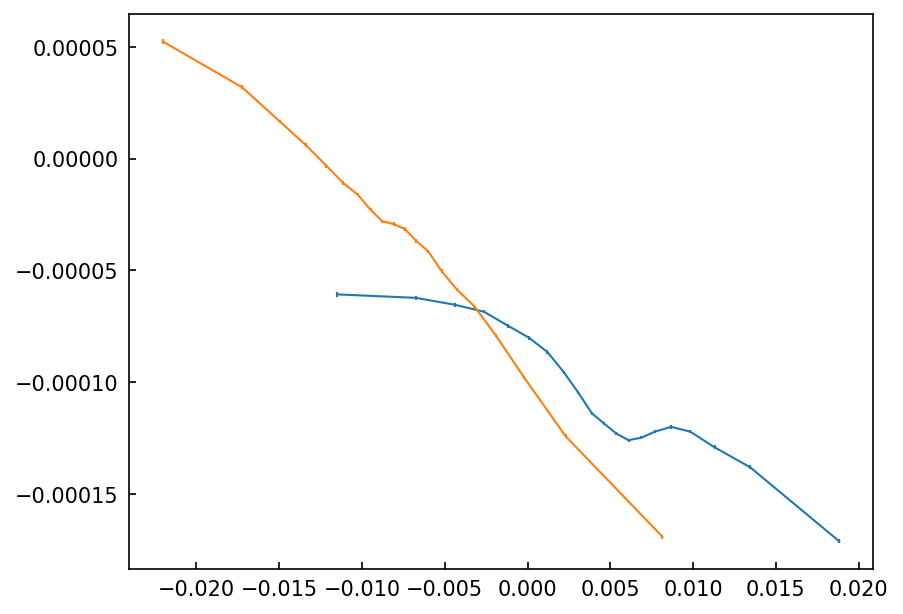

In [31]:
plt.errorbar(Xmean[2],q1_mean[2],yerr=q1_err[2],zorder=10)
plt.errorbar(Xmean[3],q2_mean[3],yerr=q1_err[2],zorder=10)
#plt.scatter(p1_hist.reshape(-1),q1_hist.reshape(-1))

### plot

<ErrorbarContainer object of 3 artists>

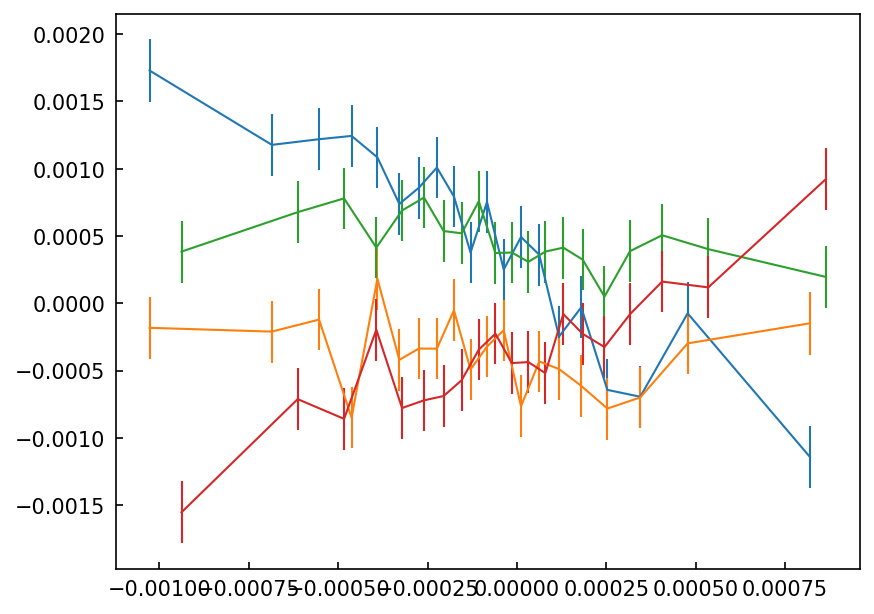

In [32]:
#plt.errorbar(Xmean[0], e2_mean[0], yerr=e2_err[0])
plt.errorbar(Xmean[0], e1_mean[0], e1_err[0])
plt.errorbar(Xmean[0], e2_mean[0], e2_err[0])
plt.errorbar(Xmean[1], e1_mean[1], e1_err[1])
plt.errorbar(Xmean[1], e2_mean[1], e2_err[1])

## scratch/testing

In [11]:
e1_sum = np.zeros(20)
q1_sum = np.zeros(20)
e1_count = np.zeros(20)

e2_sum = np.zeros(20)
q2_sum = np.zeros(20)
e2_count = np.zeros(20)

for fname in tqdm.tqdm(readable[:]):
    new = fitsio.read(f'/project/chihway/data/decade/shearcat_v2/{fname[:-12]}.fits')
    result = fitsio.read(f'/project/chihway/jackie/decade/rowe_stats/interp/{fname[:-12]}_binned.fits')
    df0, df1p, df1m, df2p, df2m = mask_default(new, result)
    for i in range(len(q1_edges)-1): 
        mask = (result['q1']>=q1_edges[i])*(result['q1']<q1_edges[i+1])
        e1_sum[i] += np.sum(new['mcal_g_noshear'][:,0][df0*mask])
        q1_sum[i] += np.sum(result['q1'][df0*mask])
        e1_count[i] += np.sum(df0*mask)
        
        mask = (result['q2']>=q2_edges[i])*(result['q2']<q2_edges[i+1])
        e2_sum[i] += np.sum(new['mcal_g_noshear'][:,1][df0*mask])
        q2_sum[i] += np.sum(result['q2'][df0*mask])
        e2_count[i] += np.sum(df0*mask)

100%|███████████████████████████████████████████████████████████████████████████████| 2982/2982 [25:29<00:00,  1.95it/s]


/software/python-anaconda-2020.02-el7-x86_64/lib/python3.7/site-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in true_divide
  """Entry point for launching an IPython kernel.
/software/python-anaconda-2020.02-el7-x86_64/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in true_divide
  


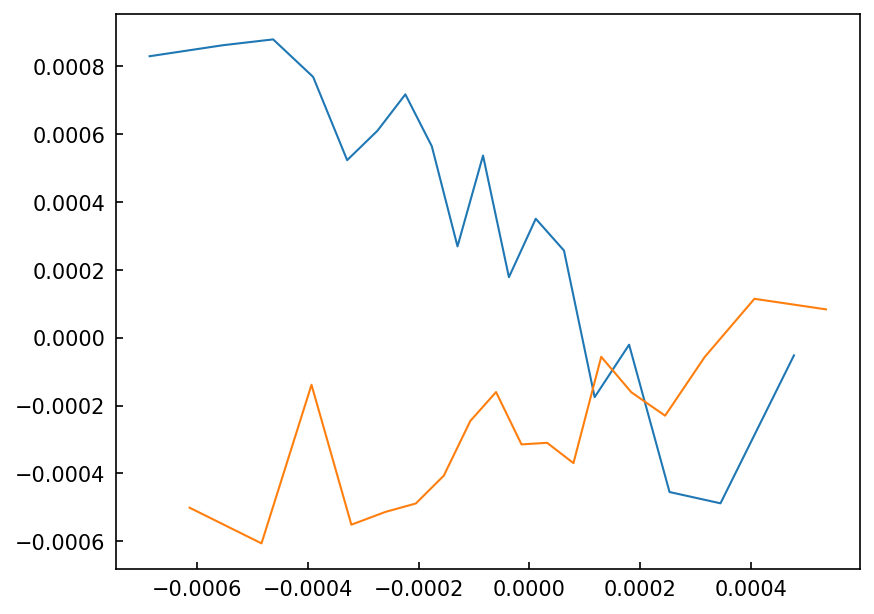

In [12]:
plt.plot(q1_sum/e1_count, e1_sum/e1_count)
plt.plot(q2_sum/e2_count, e2_sum/e2_count)

In [17]:
xbin = np.linspace(1,26625,nbinx+1) # 12*2048+2048+1
ybin = np.linspace(1,28673,nbiny+1) # 6*4096+4096+1
z_hist_test = np.zeros((nbiny,nbinx))
count_hist_test = np.zeros((nbiny,nbinx))



for fname in tqdm.tqdm(readable[:100]):
    new = fitsio.read(f'/project/chihway/data/decade/shearcat_v2/{fname[:-12]}.fits')
    result = fitsio.read(f'/project/chihway/jackie/decade/rowe_stats/interp/{fname[:-12]}_binned.fits')
    corners = np.loadtxt('/project2/chihway/dhayaa/FocalPlaneCoordOffsets.txt')
    x_focal_s = -np.nan*np.ones_like(ccdnum_s)
    y_focal_s = -np.nan*np.ones_like(ccdnum_s)

    ccdnum_s = new['ccdnum']
    x_exp_s = new['x_exp']
    y_exp_s = new['y_exp']
    coordmask = ccdnum_s[:,0,0]!=-9999
    offset_x, offset_y = corners[:,ccdnum_s[coordmask,0,0]]
    x_focal_s[coordmask,0,0] = offset_x + x_exp_s[coordmask,0,0]
    y_focal_s[coordmask,0,0] = offset_y + y_exp_s[coordmask,0,0] 
    
    ind_x = np.digitize(x_focal_s[:,0,0],xbin,right=True)-1
    ind_y = np.digitize(y_focal_s[:,0,0],ybin,right=True)-1
    ind_a = nbiny*ind_x+ind_y # 2d bin index --> 1d bin index

    z_ = np.bincount(ind_a,p1_interp[:,0,0],minlength=nbinx*nbiny) # sum e1_s with the same ind_a
    N = np.bincount(ind_a,np.ones(len(p1_interp[:,0,0])),minlength=nbinx*nbiny)

    # back to 2d bin index
    categories = np.arange(nbinx*nbiny)
    ind_x = categories//nbiny
    ind_y = categories%nbiny

    count_hist_test[ind_y,ind_x] += N
    z_hist_test[ind_y,ind_x] += z_

  0%|                                                                                           | 0/100 [00:00<?, ?it/s]


NameError: name 'p1_interp' is not defined

In [245]:
# stupid (slow) method to test binned p,q,w maps
q1 = np.zeros((nbinx,nbiny))
q2 = np.zeros((nbinx,nbiny))
count = np.zeros((nbinx,nbiny))
for xind in range(nbinx): 
    for yind in range(nbiny):
        mask = (focal_x>xbin[xind])*(focal_x<=xbin[xind+1])*(focal_y>ybin[yind])*(focal_y<=ybin[yind+1])
        count[xind][yind] += np.sum(mask)
        q1[xind][yind] += np.mean(star_e1[mask]-p1[mask])
        q2[xind][yind] += np.mean(star_e2[mask]-p2[mask])
        if count[xind,yind] == 0: 
            q1[xind,yind] = 0
            q2[xind,yind] = 0

/software/python-anaconda-2020.02-el7-x86_64/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3441: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/software/python-anaconda-2020.02-el7-x86_64/lib/python3.7/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


/software/python-anaconda-2020.02-el7-x86_64/lib/python3.7/site-packages/ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in true_divide


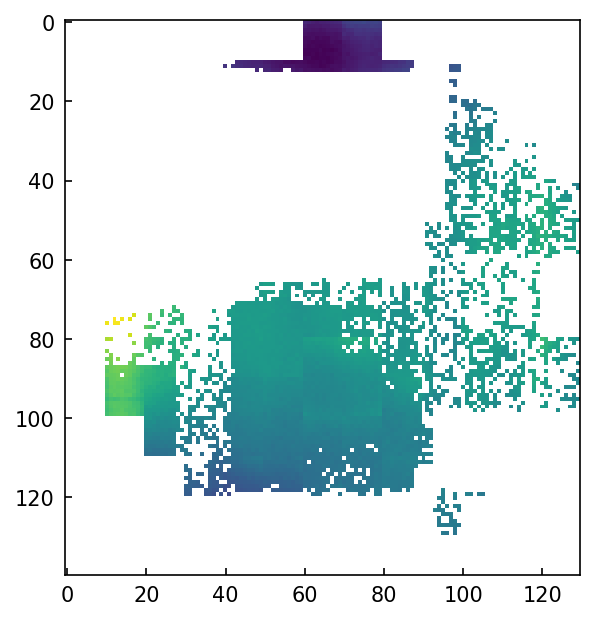

In [35]:
# interpolation test
xbin = np.linspace(1,26625,nbinx+1) # 12*2048+2048+1
ybin = np.linspace(1,28673,nbiny+1) # 6*4096+4096+1
z_hist_test = np.zeros((nbiny,nbinx))
count_hist_test = np.zeros((nbiny,nbinx))

ind_x = np.digitize(x_focal_s[:,0,0],xbin,right=True)-1
ind_y = np.digitize(y_focal_s[:,0,0],ybin,right=True)-1
ind_a = nbiny*ind_x+ind_y # 2d bin index --> 1d bin index

z_ = np.bincount(ind_a,p1_interp[:,0,0],minlength=nbinx*nbiny) # sum e1_s with the same ind_a
N = np.bincount(ind_a,np.ones(len(p1_interp[:,0,0])),minlength=nbinx*nbiny)

# back to 2d bin index
categories = np.arange(nbinx*nbiny)
ind_x = categories//nbiny
ind_y = categories%nbiny

count_hist_test[ind_y,ind_x] += N
z_hist_test[ind_y,ind_x] += z_

plt.imshow(z_hist_test/count_hist_test)

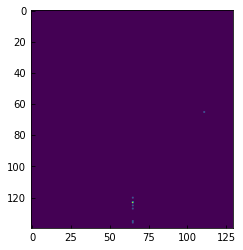

In [263]:
# domain mask test
count_hist_test = np.zeros((nbiny,nbinx))

ind_x = np.digitize(x_focal_s[:,0,0],xbin,right=True)-1
ind_y = np.digitize(y_focal_s[:,0,0],ybin,right=True)-1
#domain_mask = mask2d[ind_y,ind_x]==True

ind_a = nbiny*ind_x+ind_y # 2d bin index --> 1d bin index

N = np.bincount(ind_a,~domain_mask[:,0,0],minlength=nbinx*nbiny)

# back to 2d bin index
categories = np.arange(nbinx*nbiny)
ind_x = categories//nbiny
ind_y = categories%nbiny

count_hist_test[ind_y,ind_x] += N

plt.imshow(count_hist_test)

In [21]:
# test bin edge
above = 0
below = 0
for fname in tqdm.tqdm(fnames):
    result = fitsio.read(f'/project/chihway/jackie/decade/rowe_stats/interp/{fname}')
    
    above += np.sum(result['q2']>q2_bin[np.searchsorted(q2_cdf,50)])
    below += np.sum(result['q2']<=q2_bin[np.searchsorted(q2_cdf,50)])
print(100*below/(below+above))

100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 468.76it/s]

50.02826910211806
